## Load Libs

In [1]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from matplotlib import pyplot as plt
sns.set(style="white")

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation

%matplotlib inline

def plot_result(hist):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['acc'], label='acc')
    plt.plot(hist.history['val_acc'], label='val_acc')
    plt.title('Accuracy')

    plt.legend(loc='best')
    plt.show()

Requirement already up-to-date: seaborn in d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages (0.9.0)


Using TensorFlow backend.


## Data Schema

Column name     | Description
             ---|---
RorNumber       |    Row number
CustomerId      |    Customer id
Surname         |    Customer surname
CreditScore     |    Credit score
Geography       |    Country the customer belong to
Gender          |    Female or Male
Age             |    Customer's age
Tenure          |    Life length of customer
Balance         |    Bank balance of the customer
NumOfProducts   |    Number of product belong to the customer
HasCrCard       |    If customer has credit card
IsActiveMember  |    If customer status is active or disabled
EstimatedSalary |    Estimated salary for the customer
Exited                   |    Label, 1: Churn, 0: Not Churn

---

* 7個類別變數
* 6個數值變數
---



# Purpose: 
* 給定金融客戶Metadata, 繳費行為等等, 預測該客戶是否在未來有可能離開?

In [2]:
raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_financial_churn.csv")
raw_vl = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_vl_financial_churn.csv")
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6396,15707918,Bentley,741,Germany,Female,36,0,127675.39,2,1,0,74260.16,0
1,6055,15773013,Uvarov,633,France,Female,47,0,0.00,1,1,1,6342.84,1
2,8866,15639004,Chiemezie,668,France,Male,72,2,0.00,2,1,1,70783.61,0
3,9098,15606901,Graham,728,France,Male,43,7,0.00,2,1,0,40023.70,0
4,3865,15808960,Alleyne,620,Germany,Male,40,5,108197.11,2,1,0,49722.34,0


## Drop 不必要的欄位

In [3]:
raw.drop(['RowNumber', 'CustomerId', 'Surname'], 1, inplace=True)
raw_vl.drop(['RowNumber', 'CustomerId', 'Surname'], 1, inplace=True)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
CreditScore        7500 non-null int64
Geography          7500 non-null object
Gender             7500 non-null object
Age                7500 non-null int64
Tenure             7500 non-null int64
Balance            7500 non-null float64
NumOfProducts      7500 non-null int64
HasCrCard          7500 non-null int64
IsActiveMember     7500 non-null int64
EstimatedSalary    7500 non-null float64
Exited             7500 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 644.6+ KB


## Features setting

In [6]:
catg_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
label = 'Exited'

<br/>

---



## Base Feature Preprocessing

* Normalize ofr numeric features
* One Hot Encoding for categorical features

In [7]:
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

def basic_feature_engineer(raw, is_train=True, scaler=None):
    data = raw

    # One Hot Encoding
    catg_part = pd.get_dummies(data[catg_features])
    # -----------------------------------------------------------------------------------------
    
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    # -----------------------------------------------------------------------------------------
    
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['Exited'].copy()
    return data_x, data_y, scaler

# Trnasform raw data to foramt model recognized
tr_x, tr_y, scaler = basic_feature_engineer(raw, is_train=True)
vl_x, vl_y, _ = basic_feature_engineer(raw_vl, is_train=False, scaler=scaler)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(7500, 13) (2500, 13)


,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,1,0,0,1,0,1,0,0.931808,-0.286140,-1.726890,0.818951,0.804202,-0.449945
1,1,1,1,0,0,1,0,-0.185926,0.761549,-1.726890,-1.223103,-0.913689,-1.631281
2,1,1,1,0,0,0,1,0.176303,3.142658,-1.036539,-1.223103,0.804202,-0.510415
3,1,0,1,0,0,0,1,0.797266,0.380571,0.689338,-1.223103,0.804202,-1.045445
4,1,0,0,1,0,0,1,-0.320468,0.094838,-0.001013,0.507413,0.804202,-0.876750


## Model on Base Featue Engineering

* Network Structure: 
    * `inputs[13], 8, 8, output[1]`
* ReLU Activation Function
* Adam Optimizer
* Sigmoid Cross Entropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 112       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 3s 365us/step - loss: 0.6850 - acc: 0.7931 - val_loss: 0.6707 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.6415 - acc: 0.7936 - val_loss: 0.5896 - val_acc: 0.8044
Epoch 3/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.5362 - acc

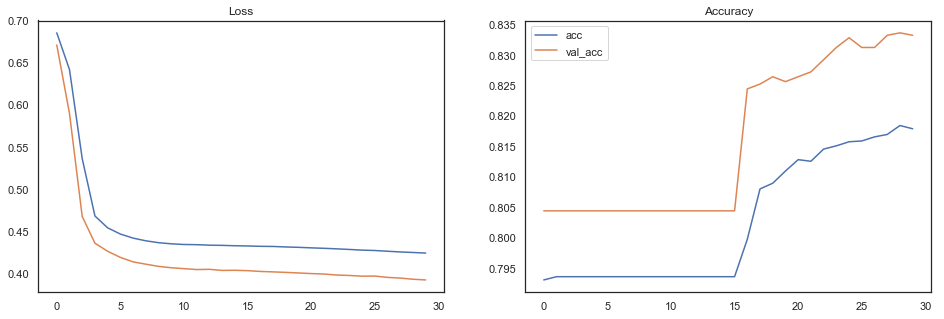

In [8]:
K.clear_session()

model = Sequential()
model.add(Dense(units = 8, kernel_initializer='uniform', activation = 'relu', input_dim = 13))
model.add(Dense(units = 8, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer='uniform', activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)
plot_result(hist)

## Add Weight of Evidence Encoding

In [9]:
def woe_encode(x, label, data):
    """Calculate the Weight of Evidence of given categorical feature and label

    :param x: Given feature name
    :param label: Label name
    :param data:
    :return: Woe encoded dictionary
    """
    total_vc = data[label].value_counts().sort_index()
    
    def woe(pipe, total_vc):
        # Count by label in this group
        group_vc = pipe[label].value_counts().sort_index()
        
        # Some class in the feature is missing, fill zero to missing class
        if len(group_vc) < len(total_vc):
            for key in total_vc.index:
                if key not in group_vc:
                    group_vc[key] = 0.
            group_vc = group_vc.sort_index()
                    
        # WOE formula
        r = ((group_vc + 0.5) / total_vc).values
        
        # Odd ratio => 1 to 0, you can define meaning of each class
        return np.log(r[1] / r[0])
        
    return data.groupby(x).apply(lambda pipe: woe(pipe, total_vc))


def woe_feature_engineer(raw, is_train=True, scaler=None):
    data = raw.copy()

    # One Hot Encoding
    catg_part = pd.get_dummies(data[catg_features])
    # -----------------------------------------------------------------------------------------
    
    # WOE encoding
    for catg_col in catg_features:
        kv = woe_encode(catg_col, 'Exited', data)
        catg_part[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    # -----------------------------------------------------------------------------------------
    
    # Normalize
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['Exited'].copy()
    # -----------------------------------------------------------------------------------------
    return data_x, data_y, scaler

tr_x, tr_y, scaler = woe_feature_engineer(raw, is_train=True)
vl_x, vl_y, _ = woe_feature_engineer(raw_vl, is_train=False, scaler=scaler)

print(tr_x.shape, vl_x.shape)
tr_x.head()

(7500, 17) (2500, 17)


,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,woe_Geography,woe_Gender,woe_HasCrCard,woe_IsActiveMember,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,1,0,0,1,0,1,0,0.610295,0.268405,-0.000576,0.344949,0.931808,-0.286140,-1.726890,0.818951,0.804202,-0.449945
1,1,1,1,0,0,1,0,-0.281315,0.268405,-0.000576,-0.402095,-0.185926,0.761549,-1.726890,-1.223103,-0.913689,-1.631281
2,1,1,1,0,0,0,1,-0.281315,-0.259455,-0.000576,-0.402095,0.176303,3.142658,-1.036539,-1.223103,0.804202,-0.510415
3,1,0,1,0,0,0,1,-0.281315,-0.259455,-0.000576,0.344949,0.797266,0.380571,0.689338,-1.223103,0.804202,-1.045445
4,1,0,0,1,0,0,1,0.610295,-0.259455,-0.000576,0.344949,-0.320468,0.094838,-0.001013,0.507413,0.804202,-0.876750


## Model (WOE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 66us/step - loss: 0.6798 - acc: 0.7912 - val_loss: 0.6505 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.5867 - acc: 0.7936 - val_loss: 0.4883 - val_acc: 0.8044
Epoch 3/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.4657 - acc:

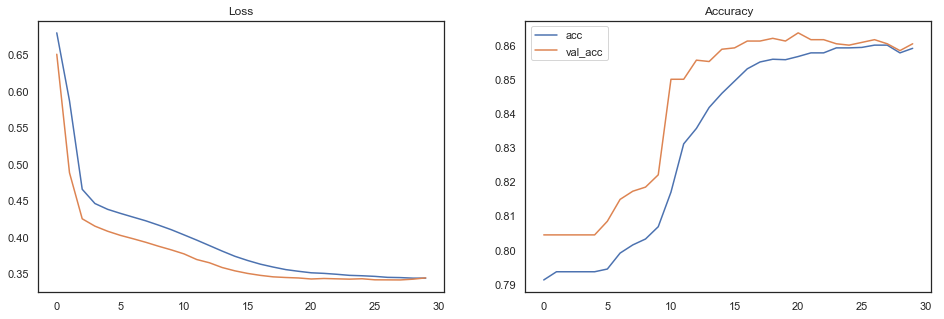

In [10]:
K.clear_session()

model = Sequential()
model.add(Dense(units = 16, kernel_initializer='uniform', activation = 'relu', input_dim = 17))
model.add(Dense(units = 16, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer='uniform', activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)
plot_result(hist)

## Bining Numeric Feature: Age, Balance, CreditScore

* `Age` Interquartile cut
* `Balance` Binary cut => 0 if  `Balance = 0` else 1
* `CreditScore` Deciles cut


In [11]:
def binning(x):
    bins = np.unique(np.percentile(x, range(0, 100, 10)))
    return np.digitize(x, bins, right=True)

def binning_feature_engineer(raw, is_train=True, scaler=None):
    data = raw.copy()

    # Numeric binning
    # Credict score
    data['binn_CreditScore'] = binning(data.CreditScore)
    # Age
    bins = np.array([14, 30, 35, 40, 45, 62])
    labels = ['~14', '14-30', '30-35', '35-40', '40-45', '45-62', '62up']
    age_map = pd.Series(labels)
    data['binn_Age'] = pd.Series(np.digitize(data.Age, bins)).map(age_map).values
    # Balance
    data['binn_Balance'] = data.Balance.map(lambda e: 0 if e == 0 else 1)
    # -----------------------------------------------------------------------------------------
    
    catg_ftrs = catg_features + ['binn_CreditScore', 'binn_Age', 'binn_Balance']
    # One Hot Encoding
    # catg_ori_cols = ['Geography', 'Gender', 'binn_CreditScore', 'binn_Age', 'binn_Balance']
    catg_part = pd.get_dummies(data[catg_ftrs])
    # -----------------------------------------------------------------------------------------
    
    # WOE encoding
    for catg_col in catg_ftrs:
        kv = woe_encode(catg_col, 'Exited', data)
        catg_part[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    # -----------------------------------------------------------------------------------------
    
    # Normalize
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['Exited'].copy()
    # -----------------------------------------------------------------------------------------        
    return data_x, data_y, scaler

tr_x, tr_y, scaler = binning_feature_engineer(raw, is_train=True)
vl_x, vl_y, _ = binning_feature_engineer(raw_vl, is_train=False, scaler=scaler)

print(tr_x.shape, vl_x.shape)
tr_x.head()

(7500, 28) (2500, 28)


,HasCrCard,IsActiveMember,binn_CreditScore,binn_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,binn_Age_14-30,...,woe_IsActiveMember,woe_binn_CreditScore,woe_binn_Age,woe_binn_Balance,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,1,0,9,1,0,1,0,1,0,0,...,0.344949,0.113494,-0.485902,0.206449,0.931808,-0.286140,-1.726890,0.818951,0.804202,-0.449945
1,1,1,5,0,1,0,0,1,0,0,...,-0.402095,0.104406,1.301735,-0.439217,-0.185926,0.761549,-1.726890,-1.223103,-0.913689,-1.631281
2,1,1,6,0,1,0,0,0,1,0,...,-0.402095,-0.159408,0.125459,-0.439217,0.176303,3.142658,-1.036539,-1.223103,0.804202,-0.510415
3,1,0,8,0,1,0,0,0,1,0,...,0.344949,-0.110582,0.159969,-0.439217,0.797266,0.380571,0.689338,-1.223103,0.804202,-1.045445
4,1,0,4,1,0,1,0,0,1,0,...,0.344949,0.002330,0.159969,0.206449,-0.320468,0.094838,-0.001013,0.507413,0.804202,-0.876750


## Model (WOE + Binning)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                928       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 65us/step - loss: 0.6698 - acc: 0.7816 - val_loss: 0.6054 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.5166 - acc: 0.7936 - val_loss: 0.4305 - val_acc: 0.8044
Epoch 3/30
7500/7500 [==============================] - 0s 18us/step - loss: 0.4426 - 

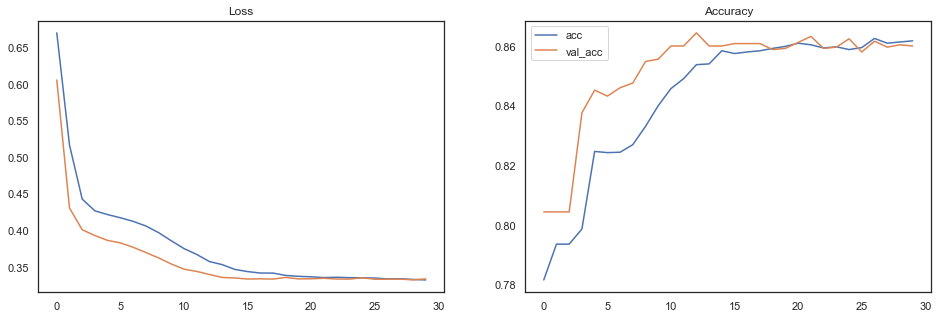

In [13]:
from keras.layers import Dropout

K.clear_session()

model = Sequential()
model.add(Dense(units = 32, kernel_initializer='uniform', activation = 'relu', input_dim = 28))
model.add(Dense(units = 16, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer='uniform', activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)
plot_result(hist)

## Statistical Encoding, Target Encoding

* Frequency encoding
* Mean encoding

In [14]:
def advanced_feature_engineer(raw, is_train=True, scaler=None):
    data = raw.copy()

    # Numeric binning
    # Credict score
    data['binn_CreditScore'] = binning(data.CreditScore)
    # Age
    bins = np.array([14, 30, 35, 40, 45, 62])
    labels = ['~14', '14-30', '30-35', '35-40', '40-45', '45-62', '62up']
    age_map = pd.Series(labels)
    data['binn_Age'] = pd.Series(np.digitize(data.Age, bins)).map(age_map).values
    # Balance
    data['binn_Balance'] = data.Balance.map(lambda e: 0 if e == 0 else 1)
    # -----------------------------------------------------------------------------------------
    
    catg_ftrs = catg_features + ['binn_CreditScore', 'binn_Age', 'binn_Balance']
    # One Hot Encoding
    catg_part = pd.get_dummies(data[catg_ftrs])
    # -----------------------------------------------------------------------------------------
    
    # WOE encoding
    for catg_col in catg_ftrs:
        kv = woe_encode(catg_col, 'Exited', data)
        catg_part[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    # -----------------------------------------------------------------------------------------
    
    # Frequency encoding, target mean encoding
    for catg_col in catg_ftrs:
        freq_proportion = data[catg_col].value_counts() / len(data)
        catg_part[f'freq_{catg_col}'] = freq_proportion.reindex(data[catg_col]).values
        catg_part[f'mean_{catg_col}'] = data.groupby(catg_col).Exited.mean()\
                                            .reindex(data[catg_col]).values
    # -----------------------------------------------------------------------------------------
    
    # Normalize
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['Exited'].copy()
    # -----------------------------------------------------------------------------------------
        
    return data_x, data_y, scaler

# tmp = advanced_feature_engineer(raw, is_train=True)
tr_x, tr_y, scaler = advanced_feature_engineer(raw, is_train=True)
vl_x, vl_y, _ = advanced_feature_engineer(raw_vl, is_train=False, scaler=scaler)

print(tr_x.shape, vl_x.shape)
tr_x.head()

(7500, 42) (2500, 42)


,HasCrCard,IsActiveMember,binn_CreditScore,binn_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,binn_Age_14-30,...,freq_binn_Age,mean_binn_Age,freq_binn_Balance,mean_binn_Balance,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,1,0,9,1,0,1,0,1,0,0,...,0.229467,0.137711,0.637467,0.242209,0.931808,-0.286140,-1.726890,0.818951,0.804202,-0.449945
1,1,1,5,0,1,0,0,1,0,0,...,0.195333,0.488737,0.362533,0.143435,-0.185926,0.761549,-1.726890,-1.223103,-0.913689,-1.631281
2,1,1,6,0,1,0,0,0,1,0,...,0.041733,0.226837,0.362533,0.143435,0.176303,3.142658,-1.036539,-1.223103,0.804202,-0.510415
3,1,0,8,0,1,0,0,0,1,0,...,0.168933,0.233623,0.362533,0.143435,0.797266,0.380571,0.689338,-1.223103,0.804202,-1.045445
4,1,0,4,1,0,1,0,0,1,0,...,0.168933,0.233623,0.637467,0.242209,-0.320468,0.094838,-0.001013,0.507413,0.804202,-0.876750


## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding)

* **Because of overfitting, we added the l2 regularization term**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                2150      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 3,451
Trainable params: 3,451
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 65us/step - loss: 0.6405 - acc: 0.7936 - val_loss: 0.5042 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 22us/step - loss: 0.4705 - acc: 0.7936 - val_loss: 0.4150 - val_acc: 0.8052
Epoch 3/30
7500/7500 [==============================] - 0s 22us/step - loss: 0.4293 - 

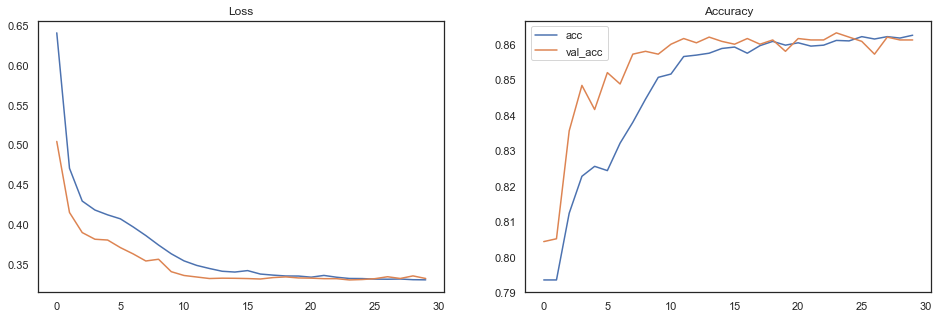

In [16]:
from keras.layers import Dropout, BatchNormalization, Activation
from keras import regularizers

K.clear_session()

model = Sequential()
model.add(Dense(units = 50, activation = 'relu', kernel_initializer='uniform', input_dim = 42))
model.add(Dense(units = 25, activation = 'relu', kernel_initializer='uniform'))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)
plot_result(hist)

## Add Polynomial Featue Engineering

* Add quradratic, cube term base on numeric features

In [26]:
def advanced_feature_engineer(raw, is_train=True, scaler=None):
    data = raw.copy()

    # Numeric binning
    # Credict score
    data['binn_CreditScore'] = binning(data.CreditScore)
    # Age
    bins = np.array([14, 30, 35, 40, 45, 62])
    labels = ['~14', '14-30', '30-35', '35-40', '40-45', '45-62', '62up']
    age_map = pd.Series(labels)
    data['binn_Age'] = pd.Series(np.digitize(data.Age, bins)).map(age_map).values
    # Balance
    data['binn_Balance'] = data.Balance.map(lambda e: 0 if e == 0 else 1)
    # -----------------------------------------------------------------------------------------
    
    catg_ftrs = catg_features + ['binn_CreditScore', 'binn_Age', 'binn_Balance']
    # One Hot Encoding
    catg_part = pd.get_dummies(data[catg_ftrs])
    # -----------------------------------------------------------------------------------------
    
    # WOE encoding
    for catg_col in catg_ftrs:
        kv = woe_encode(catg_col, 'Exited', data)
        catg_part[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    # -----------------------------------------------------------------------------------------
    
    # Frequency encoding, target mean encoding
    for catg_col in catg_ftrs:
        freq_proportion = data[catg_col].value_counts() / len(data)
        catg_part[f'freq_{catg_col}'] = freq_proportion.reindex(data[catg_col]).values
        catg_part[f'mean_{catg_col}'] = data.groupby(catg_col).Exited.mean()\
                                            .reindex(data[catg_col]).values
    # -----------------------------------------------------------------------------------------
    
    # Normalize
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['Exited'].copy()
    # -----------------------------------------------------------------------------------------

    # Include quadratic term, cube term
    for num_col in num_features:
        data_x[f'{num_col}_degree_2'] = data_x[num_col] ** 2
        data_x[f'{num_col}_degree_3'] = data_x[num_col] ** 3
    # -----------------------------------------------------------------------------------------
    return data_x, data_y, scaler

tr_x, tr_y, scaler = advanced_feature_engineer(raw, is_train=True)
vl_x, vl_y, _ = advanced_feature_engineer(raw_vl, is_train=False, scaler=scaler)

print(tr_x.shape, vl_x.shape)
tr_x.head()

(7500, 54) (2500, 54)


,HasCrCard,IsActiveMember,binn_CreditScore,binn_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,binn_Age_14-30,...,Age_degree_2,Age_degree_3,Tenure_degree_2,Tenure_degree_3,Balance_degree_2,Balance_degree_3,NumOfProducts_degree_2,NumOfProducts_degree_3,EstimatedSalary_degree_2,EstimatedSalary_degree_3
0,1,0,9,1,0,1,0,1,0,0,...,0.081876,-0.023428,2.982148,-5.149841e+00,0.670681,0.549255,0.646741,0.520110,0.202451,-0.091092
1,1,1,5,0,1,0,0,1,0,0,...,0.579956,0.441665,2.982148,-5.149841e+00,1.495981,-1.829740,0.834827,-0.762772,2.661079,-4.340968
2,1,1,6,0,1,0,0,0,1,0,...,9.876301,31.037837,1.074413,-1.113671e+00,1.495981,-1.829740,0.646741,0.520110,0.260524,-0.132975
3,1,0,8,0,1,0,0,0,1,0,...,0.144834,0.055120,0.475187,3.275649e-01,1.495981,-1.829740,0.646741,0.520110,1.092956,-1.142625
4,1,0,4,1,0,1,0,0,1,0,...,0.008994,0.000853,0.000001,-1.038016e-09,0.257468,0.130643,0.646741,0.520110,0.768690,-0.673949


## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding + Polynominal)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1760      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 1s 96us/step - loss: 0.6492 - acc: 0.7925 - val_loss: 0.5293 - val_acc: 0.8100
Epoch 2/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.4635 - acc: 0.8053 - val_loss: 0.3987 - val_acc: 0.8276
Epoch 3/30
7500/7500 [==============================] - 0s 19us/step - loss: 0.4017 - 

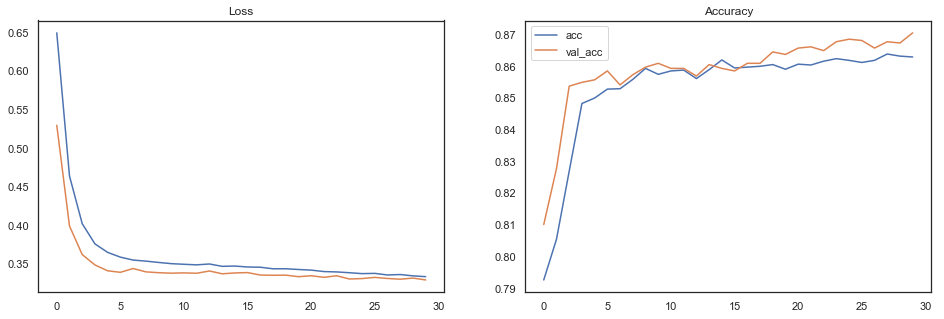

In [27]:
K.clear_session()

model = Sequential()
model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform', input_dim = 54))
model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)
plot_result(hist)